In [1]:
import sys , types
import pandas as pd

try:
    import keras
    keras.__version__ = '2.12.0'
except ImportError:
    pass
# 2) Create a tf_keras alias so Transformers can import it
if 'tf_keras' not in sys.modules:
    try:
        import keras as _k
        m = types.ModuleType('tf_keras')
        # Copy attributes from keras
        for attr in dir(_k):
            setattr(m, attr, getattr(_k, attr))
        sys.modules['tf_keras'] = m
    except ImportError:
        pass



# Setup project root and import path
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)

# Download raw data
from src.data_loader import DataLoader

# Preprocess raw filings
from src.preprocessing import Preprocessor

# Build main dataset
from src.build_dataset import DatasetBuilder

# Enrich with market data (local CSV loader)
from src.market_data import LocalMarketDataLoader

# Compute linguistic features
from src.features import FeatureEngineer

# Generate TF-IDF features for SVM
from src.vectorization import TfidfFeatureExtractor

# Generate embedding features for neural models
from src.vectorization import EmbeddingFeatureExtractor




In [2]:

# Define tickers and download directory
tickers = ["AAPL", "TSLA", "MSFT"]
#tickers = ["AAPL", "TSLA", "JPM", "CVX", "KO", "AMC", "GME", "PLTR", "MSFT", "JNJ"]
loader = DataLoader(delay=0.5)
for t in tickers:
    loader.fetch_10k_filings(t, count=1)

[+] Ticker: AAPL → CIK: 0000320193
[+] Found 1 10-K filings
Downloaded: AAPL_10K_2024.txt
[+] Ticker: TSLA → CIK: 0001318605
[+] Found 1 10-K filings
Downloaded: TSLA_10K_2024.txt
[+] Ticker: MSFT → CIK: 0000789019
[+] Found 1 10-K filings
Downloaded: MSFT_10K_2024.txt


In [3]:
pp = Preprocessor()
pp.batch_preprocess()

Preprocessing AAPL_10K_2024.txt
Preprocessed: c:\Users\theod\OneDrive\Documents\GitHub\nlp-financial-reports\data\processed\AAPL_10K_2024.txt
Preprocessing MSFT_10K_2024.txt
Preprocessed: c:\Users\theod\OneDrive\Documents\GitHub\nlp-financial-reports\data\processed\MSFT_10K_2024.txt
Preprocessing TSLA_10K_2024.txt
Preprocessed: c:\Users\theod\OneDrive\Documents\GitHub\nlp-financial-reports\data\processed\TSLA_10K_2024.txt


In [4]:
builder = DatasetBuilder()
builder.save()

       filing_id ticker  year  \
0  AAPL_10K_2024   AAPL  2024   
1  MSFT_10K_2024   MSFT  2024   
2  TSLA_10K_2024   TSLA  2024   

                                               item1  \
0  Item 1. Business Company Background The Compan...   
1  ITEM 1. B USINESS GENERAL Embracing Our Future...   
2  ITEM 1. BUSINESS Overview We design, develop, ...   

                                              item1a  \
0  Item 1A. Risk Factors The Company’s business, ...   
1  ITEM 1A. RIS K FACTORS Our operations and fina...   
2  ITEM 1A. RISK FACTORS You should carefully con...   

                                               item7  
0  Item 7. Management’s Discussion and Analysis o...  
1  ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS O...  
2  ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS O...  
Dataset saved to: c:\Users\theod\OneDrive\Documents\GitHub\nlp-financial-reports\data\processed\reports.parquet


In [6]:

from pathlib import Path
cwd = Path.cwd()

if (cwd / "src").exists():
    project_root_mkt = cwd
else:
    project_root_mkt = cwd.parent

data_dir      = project_root_mkt / "data"  
processed_dir = data_dir / "processed"
reports_file  = processed_dir / "reports.parquet"

# Map tickers to your own CSV paths
price_files = {
        "AAPL": "C:/Users/theod/OneDrive/Bureau/Theo/Master IEF Dauphine/S2/NLP/data/AAPL.csv",
        "MSFT": "C:/Users/theod/OneDrive/Bureau/Theo/Master IEF Dauphine/S2/NLP/data/MSFT.csv",
        "TSLA": "C:/Users/theod/OneDrive/Bureau/Theo/Master IEF Dauphine/S2/NLP/data/TSLA.csv",
    }

reports = pd.read_parquet(str(reports_file))
market_loader = LocalMarketDataLoader(price_files)
enriched = market_loader.enrich(reports)
market_loader.save(enriched)

[✓] Saved enriched data to c:\Users\theod\OneDrive\Documents\GitHub\nlp-financial-reports\data\processed\reports_with_market.parquet


Résumé des statistiques par ticker                                 25%        50%        75%  count        max  \
ticker                                                                        
AAPL   abnormal7d         -0.000269  -0.000269  -0.000269    1.0  -0.000269   
       fog_index          23.237592  23.237592  23.237592    1.0  23.237592   
       hedge_ratio         0.011547   0.011547   0.011547    1.0   0.011547   
       lexical_diversity   0.147275   0.147275   0.147275    1.0   0.147275   
       passive_ratio       0.065282   0.065282   0.065282    1.0   0.065282   
MSFT   abnormal7d          0.037102   0.037102   0.037102    1.0   0.037102   
       fog_index          20.716729  20.716729  20.716729    1.0  20.716729   
       hedge_ratio         0.026953   0.026953   0.026953    1.0   0.026953   
       lexical_diversity   0.161173   0.161173   0.161173    1.0   0.161173   
       passive_ratio       0.048837   0.048837   0.048837    1.0   0.048837   
TSLA   abnormal7d

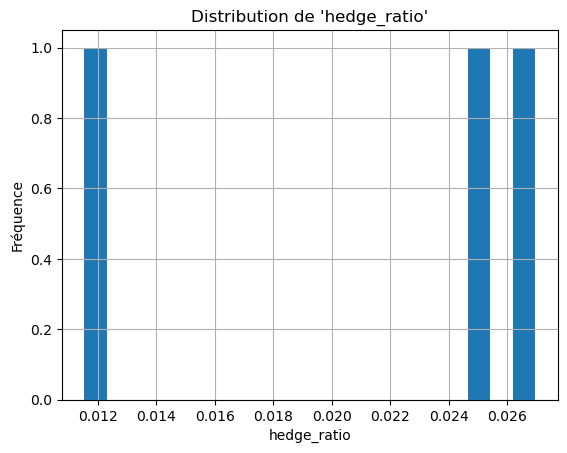

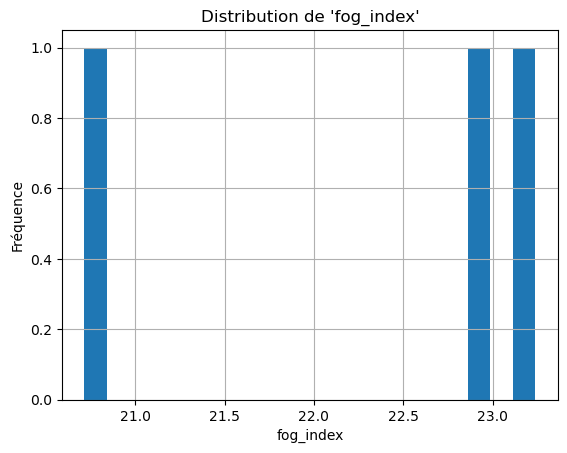

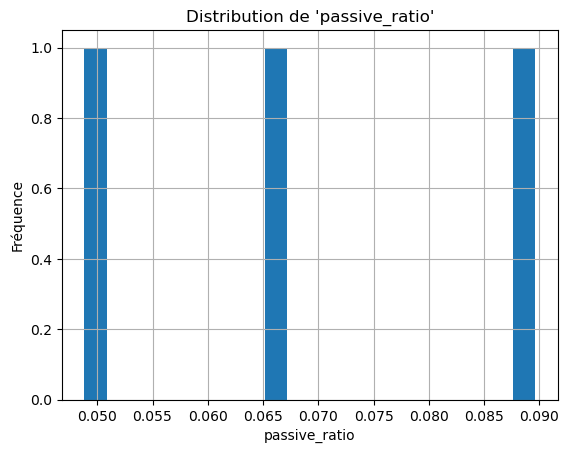

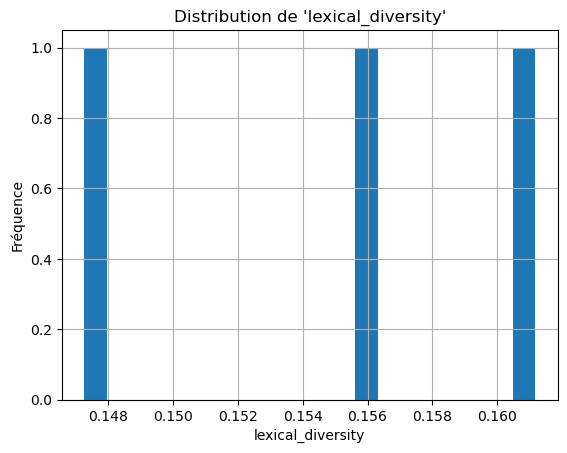

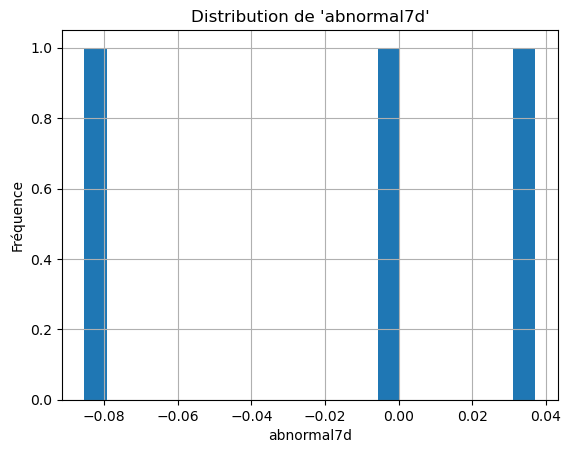

<Figure size 640x480 with 0 Axes>

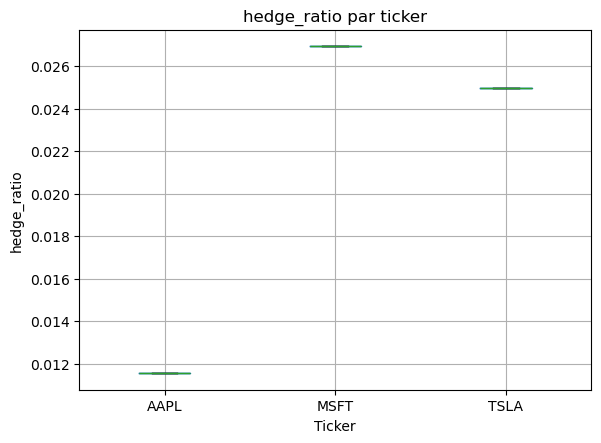

<Figure size 640x480 with 0 Axes>

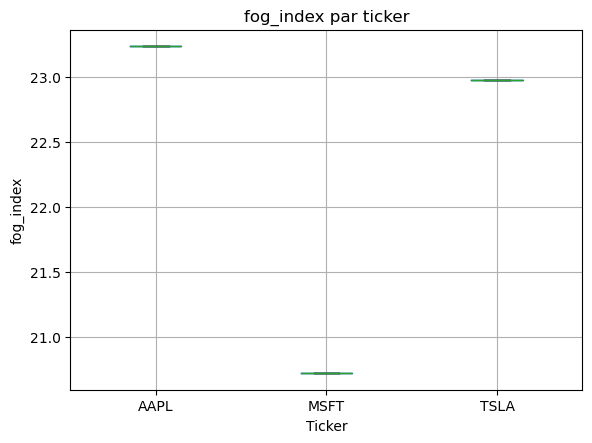

<Figure size 640x480 with 0 Axes>

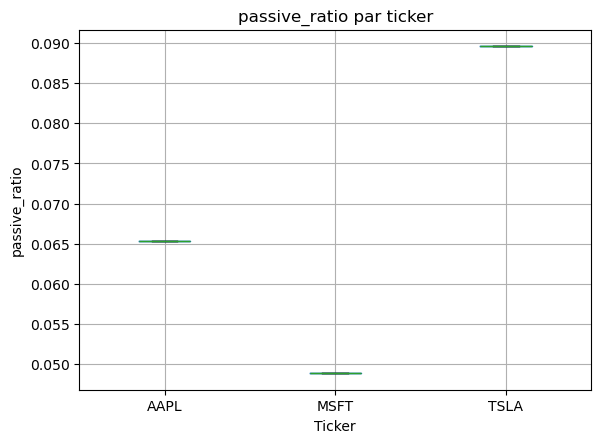

<Figure size 640x480 with 0 Axes>

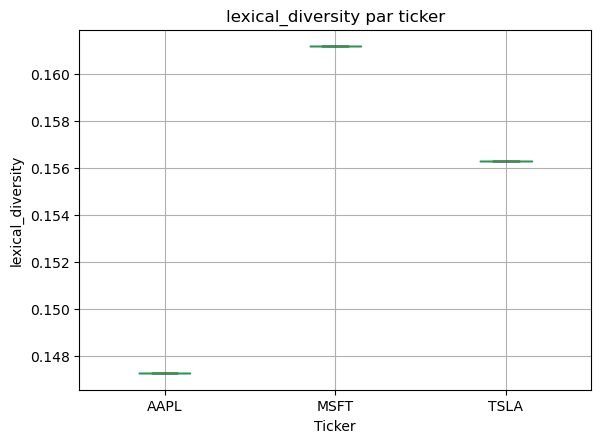

<Figure size 640x480 with 0 Axes>

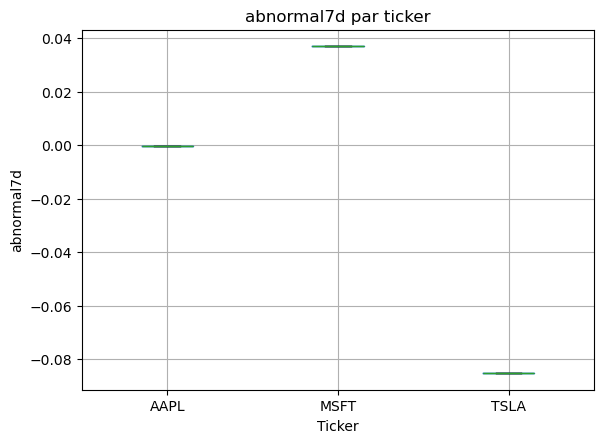

In [13]:
#!pip install textstat
#!pip install spacy
import matplotlib.pyplot as plt


reports_file  = processed_dir / "reports_features.parquet"

fe = FeatureEngineer()
df = pd.read_parquet(str(reports_file))


# 1Statistiques descriptives par ticker
stats = df.groupby('ticker')[[
    'hedge_ratio',
    'fog_index',
    'passive_ratio',
    'lexical_diversity',
    'abnormal7d'
]].describe().stack(level=0)
print("Résumé des statistiques par ticker", stats)

# 2️⃣ Histogrammes individuels pour chaque feature
for feat in ['hedge_ratio', 'fog_index', 'passive_ratio', 'lexical_diversity', 'abnormal7d']:
    plt.figure()
    df[feat].hist(bins=20)
    plt.title(f"Distribution de '{feat}'")
    plt.xlabel(feat)
    plt.ylabel("Fréquence")
    plt.show()

# 3️⃣ Boxplots par ticker pour chaque feature
for feat in ['hedge_ratio', 'fog_index', 'passive_ratio', 'lexical_diversity', 'abnormal7d']:
    plt.figure()
    df.boxplot(column=feat, by='ticker')
    plt.title(f"{feat} par ticker")
    plt.suptitle("")  # Supprime le titre automatique
    plt.xlabel("Ticker")
    plt.ylabel(feat)
    plt.show()


In [8]:

# Generate TF-IDF features for SVM
import pandas as pd
from src.vectorization import TfidfFeatureExtractor

project_root_feature = os.path.abspath(os.path.join(os.getcwd(), ".."))  # monte d’un cran
features_file = os.path.join(project_root, "data", "processed", "reports_features.parquet")
df_feats = pd.read_parquet(features_file)
texts = df_feats['item1a']  # focus on Risk Factors

tfidf_extractor = TfidfFeatureExtractor(max_features=5000,
                                         pca_components=0)
                                         
tfidf_matrix = tfidf_extractor.fit_transform(texts)
tfidf_extractor.save(tfidf_matrix)

[✓] Saved TF-IDF features to c:\Users\theod\OneDrive\Documents\GitHub\nlp-financial-reports\data\processed\tfidf_features.parquet


In [9]:
embed_extractor = EmbeddingFeatureExtractor(model_name='all-MiniLM-L6-v2')
                                        
embeddings = embed_extractor.transform(texts)
embed_extractor.save(embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[✓] Saved embedding features to c:\Users\theod\OneDrive\Documents\GitHub\nlp-financial-reports\data\processed\embedding_features.parquet
